In [141]:
import pymc as pm
import pdfplumber
import arviz as az
import numpy as np
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr

# CMIP data
Use AMOC, SSS, CUC from Terhaar et al 2026.  Read it in and do a sanity check:

In [142]:
terhaar=pd.read_csv("../DATA/Terhaar.txt",header=None,sep=" ")
models=terhaar[0].values
terhaar

,0,1,2,3
0,ACCESS-ESM1-5,18.66,33.83,0.542
1,CanESM5,12.22,33.85,0.544
2,CESM2,18.17,33.65,0.537
3,CMCC-ESM2,14.10,33.72,0.546
4,EC-Earth3-CC,19.03,33.83,0.520
5,GFDL-ESM4,17.94,33.99,0.555
6,IPSL-CM6A-LR,12.79,33.84,0.529
7,MIROC-ES2L,11.75,33.96,0.534
8,MPI-ESM1-2-LR,17.71,33.90,0.519
9,MRI-ESM2-0,18.93,34.11,0.560


# Beta and Gamma
Now read in the Terhaar et al beta and gamma and compare it to Chris Jones's table (from Arora et al).  All Chris's values are at 2xCO2.  The overlap is not exact but close enough?

In [157]:
terhaar_bg=xr.load_dataset("../DATA/beta_gamma_terhaar.nc",decode_times=False)
chris_bg=pd.read_csv("../DATA/OFFLINE.csv")
overlap=chris_bg[25:][chris_bg[25:].model.isin(terhaar_bg.model.values)]
overlap_models=overlap.model
CHRIS_BG=overlap["βO (PgC ppm-1)"].astype(float)

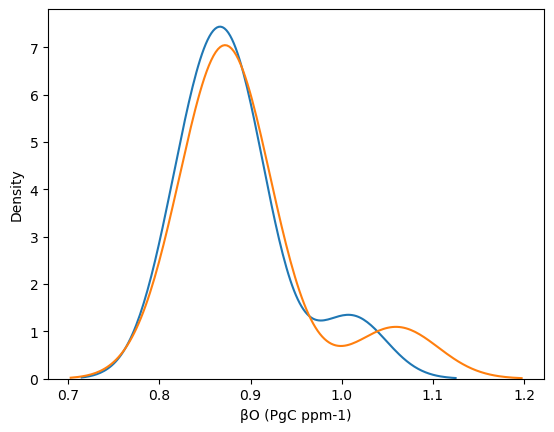

In [159]:
beta_2x=terhaar_bg.beta.isel(time=69)
beta_4x=terhaar_bg.beta.isel(time=-1)
sns.kdeplot(beta[beta_2x.model.isin(overlap_models)])
sns.kdeplot(CHRIS_BG)
beta_time=terhaar_bg.beta

# Standardization
Standardize everything to make the sampler run faster.  We'll rescale the resulting posterior afterwards to give us physical units.

In [160]:

beta=beta_4x
AMOC=terhaar[1].values
SSS=terhaar[2].values
CUC=terhaar[3].values




#Standardize everything to make the sampler behave better

AMOC_s = (AMOC - AMOC.mean()) / AMOC.std()
SSS_s  = (SSS - SSS.mean()) / SSS.std()
CUC_s  = (CUC - CUC.mean()) / CUC.std()
beta_s = (beta - beta.mean()) / beta.std()

#Observations

AMOC_obs_mean_s = (17.02 - AMOC.mean()) / AMOC.std()
AMOC_obs_sd_s   = 0.35 / AMOC.std()

SSS_obs_mean_s  = (34.04 - SSS.mean()) / SSS.std()
SSS_obs_sd_s    = 0.04 / SSS.std()

CUC_obs_mean_s  = (0.546 - CUC.mean()) / CUC.std()
CUC_obs_sd_s    = 0.003 / CUC.std()

# Forward model
Fit a simple forward model to the 4xCO2 $\beta_O$ values.  Here, we assume the values of AMOC,SSS,CUC predict $\beta_O$:
$$\beta_O = a AMOC + b SSS + c CUC+d$$
Or, in a Bayesian framework:
$$ \beta_m \sim N( a AMOC_m + b SSS_m + c CUC_m+d,\sigma_{reg}^2)$$
for each CMIP model $m$.  This allows us to learn full posteriors for each of the regression coefficients.

In [161]:
with pm.Model() as regmodel:
    a = pm.Normal("a",0,1)
    b = pm.Normal("b",0,1)
    c=pm.Normal("c",0,10)
    d=pm.Normal("d",0,1)
    
    
    # ----- Emergent constraint in CMIP -----
    
    sigma=pm.HalfNormal("sigma",1)
    mu = a*AMOC_s + b*SSS_s + c*CUC_s + d
    pm.Normal("lik",mu=mu,sigma=sigma,observed=beta_s)
    
    # ----- Observational ocean stuff (with uncertainty) -----
    AMOC_obs = pm.Normal("AMOC_obs",
                         AMOC_obs_mean_s,
                         AMOC_obs_sd_s)

    SSS_obs = pm.Normal("SSS_obs",
                        SSS_obs_mean_s,
                        SSS_obs_sd_s)

    CUC_obs = pm.Normal("CUC_obs",
                        CUC_obs_mean_s,
                        CUC_obs_sd_s)

    # ----- DETERMINISTIC constraint in the observations -----
    beta_obs = pm.Deterministic(
        "beta_obs",
        a*AMOC_obs + b*SSS_obs + c*CUC_obs + d
    )


In [162]:
with regmodel:
    regtrace=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d, sigma, AMOC_obs, SSS_obs, CUC_obs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


This looks reasonable!  The mean of the constrained $\beta_O$ is wider but that's to be expected: we're taking into account the uncertainty in the regression terms.

<Axes: title={'center': 'x'}, ylabel='Density'>

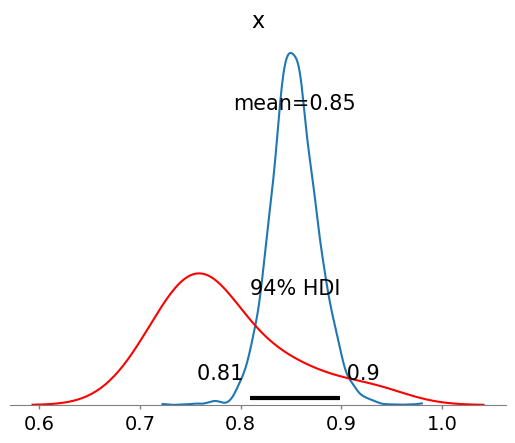

In [167]:
beta_forward = regtrace.posterior.beta_obs * beta.std() + beta.mean()
az.plot_posterior(beta_forward)
sns.kdeplot(beta,c="r")

# Contrast with simple OLS
This gives the same results as in the paper.  Note that there's no uncertainty in the coefficients here.

In [164]:
from sklearn.linear_model import LinearRegression
OBSERVABLE=np.array([AMOC,SSS,CUC]).T


In [165]:
reg = LinearRegression(fit_intercept=True).fit(OBSERVABLE, beta)

In [166]:
print(reg.coef_)
print(reg.intercept_)

[0.00838475 0.26744782 2.21049436]
-9.599459627633856


# Time dependence
Let's do the same predictive thing, but with the coefficients time dependent.

In [168]:
beta_time_s=(beta_time-beta_time.mean(dim="model"))/beta_time.std(dim="model")


In [238]:
coords={"time":np.arange(140),\
       "model":beta.model.values}
with pm.Model(coords=coords) as regmodel_time:
    
    # Coefficients vary over time
    a = pm.Normal("a", 0, 1, dims="time")
    b = pm.Normal("b", 0, 1, dims="time")
    c = pm.Normal("c", 0, 10, dims="time")
    d = pm.Normal("d", 0, 1, dims="time")
    
    # Data (model dimension)
    AMOC = pm.Data("AMOC_s", AMOC_s, dims="model",mutable=False)
    SSS  = pm.Data("SSS_s", SSS_s, dims="model",mutable=False)
    CUC  = pm.Data("CUC_s", CUC_s, dims="model",mutable=False)
    
    # Observation noise
    sigma = pm.HalfNormal("sigma", 1,dims="time")
    
    # Expand dims for broadcasting:
    # (time, 1) * (1, model) → (time, model)
    mu = (
        a[:, None] * AMOC[None, :] +
        b[:, None] * SSS[None, :]  +
        c[:, None] * CUC[None, :]  +
        d[:, None]
    )
    
    pm.Normal("lik", mu=mu, sigma=sigma[:,None], 
              observed=beta_time_s, dims=("time", "model"))
    
    
        # ----- Observational predictors (with uncertainty) -----
    AMOC_obs = pm.Normal("AMOC_obs",
                         AMOC_obs_mean_s,
                         AMOC_obs_sd_s)

    SSS_obs = pm.Normal("SSS_obs",
                        SSS_obs_mean_s,
                        SSS_obs_sd_s)

    CUC_obs = pm.Normal("CUC_obs",
                        CUC_obs_mean_s,
                        CUC_obs_sd_s)

    # ----- Emergent constraint in the observations -----
    beta_obs = pm.Deterministic(
        "beta_obs",
        a*AMOC_obs + b*SSS_obs + c*CUC_obs + d
    ,dims="time")
    timetrace=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d, sigma, AMOC_obs, SSS_obs, CUC_obs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [239]:
# Put back original units
pred_beta=(timetrace.posterior.beta_obs * beta_time.std(dim="model"))+beta_time.mean(dim="model")

# Comparison
The constraint looks pretty similar to Figure 1a

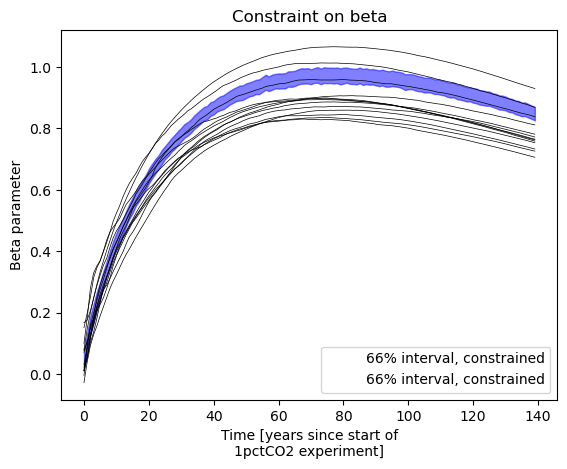

In [240]:

#az.plot_hdi(coords["time"],beta_time.T,smooth=False,color="k",plot_kwargs={"label":"95% interval in CMIP"})
tmp=[beta_time.isel(model=i).plot(c="k",lw=.5) for i in range(13)]
az.plot_hdi(coords["time"],pred_beta,color="b",smooth=False,plot_kwargs={"label":"66% interval, constrained"},hdi_prob=.66)
plt.title("Constraint on beta")
plt.legend()

# Inverse modeling
Semantics time: the relationship presented in Terhaar et al is a a prediction, not a constraint.  It answers the question: 

“Given the empirical relationship across models, what is the expected value of $\beta_O$ at the observed [AMOC,SSS,CUC]?". 

In this case, EVERYTHING we know about $\beta_O$ comes from the relationship in the climate models, and there's no way to update our understanding with new evidence.

But in a Bayesian framework, we'd update a posterior:
$$ P(\beta_O | \rm{observables}) \propto P(\rm{observables} | \beta_O)P(\beta_O)$$

This is much better for the assessment framework!  It lets us combine multiple lines of evidence and sequentially update the posterior for $\beta_O$.  The Bayesian approach evaluates which values of $\beta_O$
 remain plausible after combining prior beliefs with the model-derived likelihood of the observations.
 
 For more information on this approach, see eg https://cp.copernicus.org/articles/16/1715/2020/#bib1.bibx56

Let's let $\mathcal{O}= (AMOC,SSS,CUC)$ be the observables.
In the CMIP archive, we'll model each ESM $m$'s observables as
 $$\mathcal{O}^m \sim MN(\mu,\Sigma) $$
 with
 $$ \mu = A + B \log \beta_O^m$$
 and find posteriors for the coefficients A and B (now 3-D vectors).  Now, we'll assume that the "true" value of the observables in the real world $\mathcal{O}^*$ relates to the "true" value of $\beta_O$ in the real world using the same relationship:
 $$\mathcal{O}^* \sim MN(A+B  \log \beta_O,\Sigma)$$
 But we don't know the real-world AMOC,SSS,CUC exactly- we have uncertain observations.
 SO we have to add another level to the hierarchy:
 
$$\mathcal{O}_{obs} \sim MN(\mathcal{O}^*,\Sigma_{obs})$$
 
 where $\Sigma_{obs}$=diag(AMOC_obs_variance,SSS_obs_variance,CUC_obs_variance).

In [230]:


#Standardize everything to make the sampler behave better

AMOC_s = (AMOC - AMOC.mean()) / AMOC.std()
SSS_s  = (SSS - SSS.mean()) / SSS.std()
CUC_s  = (CUC - CUC.mean()) / CUC.std()
beta_s = (beta - beta.mean()) / beta.std()

#Observations

AMOC_obs_mean_s = (17.02 - AMOC.mean()) / AMOC.std()
AMOC_obs_sd_s   = 0.35 / AMOC.std()

SSS_obs_mean_s  = (34.04 - SSS.mean()) / SSS.std()
SSS_obs_sd_s    = 0.04 / SSS.std()

CUC_obs_mean_s  = (0.546 - CUC.mean()) / CUC.std()
CUC_obs_sd_s    = 0.003 / CUC.std()



beta_m = beta.values
theta_m = np.log(beta.values)
O_m = np.stack([AMOC_s, SSS_s, CUC_s]).T

O_obs = np.array([AMOC_obs_mean_s,
                  SSS_obs_mean_s,
                  CUC_obs_mean_s])

O_obs_unc = np.array([AMOC_obs_sd_s,
                      SSS_obs_sd_s,
                      CUC_obs_sd_s])

M = len(beta_m)

with pm.Model() as inversemodel:

    # ----------------------------
    # Emergent relationship priors
    # ----------------------------
    a = pm.Normal("a", mu=0.0, sigma=10.0, shape=3)
    b = pm.Normal("b", mu=0.0, sigma=10.0, shape=3)

    chol, corr, sigmas = pm.LKJCholeskyCov(
        "chol_cov",
        n=3,
        eta=2.0,
        sd_dist=pm.HalfNormal.dist(5.0),
        compute_corr=True,
    )

    Sigma = pm.Deterministic("Sigma", chol @ chol.T)

    # ----------------------------
    # Learn emergent constraint from models
    # ----------------------------
    #mu_models = a + b * beta_m[:, None]
    mu_models = a + b * theta_m[:, None]
    pm.MvNormal(
        "model_obs",
        mu=mu_models,
        chol=chol,
        observed=O_m,
    )

    # ----------------------------
    # Prior for beta
    # ----------------------------
    #beta_true = pm.Normal("beta_true", 0, 1)
    theta = pm.Normal("theta",0,1)
    # ----------------------------
    # Latent true climate observable
    # ----------------------------
    #mu_obs = a + b * beta_true
    mu_obs = a+b*theta

    O_true = pm.MvNormal(
        "O_true",
        mu=mu_obs,
        chol=chol,
        shape=3,
    )

    # ----------------------------
    # Measurement model
    # ----------------------------
    pm.Normal(
        "obs",
        mu=O_true,
        sigma=O_obs_unc,
        observed=O_obs,
    )
    
    beta_true=pm.Deterministic("beta_true",pm.math.exp(theta))
    
    inversetrace = pm.sample(2000, tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, chol_cov, theta, O_true]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 55 seconds.


# Updatable emergent constraint
It still works!  Note that the posterior of the constrained $\beta_O$ using the inverse model approach is wider than the forward model approach.  This is because we've put a prior on $\beta_O \sim LogNormal(0,1)$ which allows $\beta$ to (conceivably) be larger or smaller than simulated by the CMIP6 models. The OLS method, by contrast, treats the models as independent samples of reality.

(0.6, 1.2)

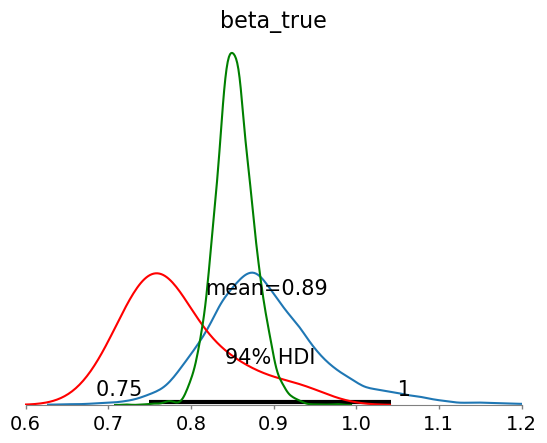

In [237]:
az.plot_posterior(inversetrace.posterior.beta_true)#*beta.std()+beta.mean())
sns.kdeplot(beta,c="r",label="CMIP6")
sns.kdeplot(beta_forward.values.flatten(),c="g",label="forward model")
plt.xlim(0.6,1.2)

The main advantage of the Bayesian emergent constraint is that it treats inference about $\beta_O$
 as an updating problem rather than a one-off prediction. This means new, independent lines of evidence about 
$\beta_O$ (additional observations, process understanding, paleoclimate constraints, whatever) can be incorporated coherently through further Bayesian updating. In contrast, an OLS-based constraint collapses the relationship to a fixed regression line- essentially defining $\beta_O$ as "the thing that's a linear combination of three observable oceanic variables." This makes it much harder to integrate new information beyond refitting the model. Even though i Bayesian framework is a cumulative, modular structure for learning about unobservable quantities, allowing evidence to be added sequentially without discarding or implicitly overwriting previous assumptions.